In [ ]:
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer,TextVectorization, Embedding,LayerNormalization, ReLU, Dropout,Input, Dense, SimpleRNN
from tensorflow.keras.metrics import mean_squared_error, Mean
from tensorflow.keras.models import Sequential
from tensorflow.data import Dataset
import tensorflow.keras.backend as K
from tensorflow import math,newaxis, linalg ,matmul, reshape, shape, transpose, equal ,cast, float32, GradientTape,TensorSpec, function, int64, argmax,data,train,reduce_sum
from tensorflow.keras.layers import Layer
from tensorflow.keras.backend import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.metrics import Mean
from tensorflow.keras.losses import sparse_categorical_crossentropy
from time import time
from pickle import dump

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Transformer_Project/English_German_New.csv")
#Read the csv file stored in drive
train_df['english'] = pd.Series(train_df['english'], dtype = "string")
train_df['german'] = pd.Series(train_df['german'], dtype = "string")
train_df = train_df.dropna()
# train_df['length'] = train_df['english_sentence'].apply(lambda x: len(x.split()))
# train_df = train_df[train_df['length'] < 100]
train_df.reset_index(drop = True, inplace = True)
#train_df.drop('length', inplace = True, axis =1)
train_df.head()

,Unnamed: 0,german,english,length
0,0,Hallo!,Hi.,1
1,1,Grüß Gott!,Hi.,1
2,2,Lauf!,Run!,1
3,3,Potzdonner!,Wow!,1
4,4,Donnerwetter!,Wow!,1


In [ ]:
train_df.drop('Unnamed: 0', axis = 1, inplace = True)

In [ ]:
def remove_punctuation(x): #Remove unwanted character such as punctuations, special characters etc in the source language
    return re.sub("[^\w\s]", "", x)

eng = train_df['english']
german = train_df['german']
german = german.apply(lambda x: remove_punctuation(x))
eng = eng.apply(lambda x: remove_punctuation(x))
eng = eng.apply(lambda x: '<SOS> ' + x + " <EOS>") # Add EOS and SOS token for source
german = german.apply(lambda x: '<SOS> ' + x + " <EOS>") # Add EOS and SOS token for target

In [ ]:
import warnings
warnings.filterwarnings("ignore")
eng_vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=10000,output_mode='int',output_sequence_length=50)
german_vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=10000,output_mode='int',output_sequence_length=50)

input_raw = tf.data.Dataset.from_tensor_slices(tf.cast(eng, tf.string))
target_raw = tf.data.Dataset.from_tensor_slices(tf.cast(german, tf.string))
eng_vectorize_layer.adapt(input_raw)
german_vectorize_layer.adapt(target_raw)

inputs = input_raw.map(eng_vectorize_layer)
target = target_raw.map(german_vectorize_layer)

inputs_vocab_size = eng_vectorize_layer.vocabulary_size()
target_vocab_size = german_vectorize_layer.vocabulary_size()
sequence_length = 50

In [ ]:
def loss_fcn(target, prediction):
    #Create a masking filter which returns 1 if the value is 0 else 0 otherwise
    mask = math.logical_not(equal(target,0))
    mask = cast(mask, tf.float32)
    
    #Compute a sparse categorical cross-entropy loss on masked values
    loss = tf.metrics.sparse_categorical_crossentropy(target, prediction, from_logits=True) * mask
    #Average loss over unmaksed values
    return math.reduce_sum(loss)/math.reduce_sum(mask)

def accuracy_fcn(target, prediction):
    #Create mask to ingnore zero padded values
    mask = math.logical_not(math.equal(target,0))
    
    accuracy = equal(target, argmax(prediction, axis =2))
    accuracy = math.logical_and(mask, accuracy)
    
    mask = cast(mask, float32)
    accuracy = cast(accuracy, float32)
    
    return math.reduce_sum(accuracy)/math.reduce_sum(mask)

In [ ]:
#Vaswani et.al proposed that learning rate increase lineary until certain warmup steps and then decrease proportionally to the inverse square root
class LRScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000, **kwargs):
        super().__init__(**kwargs)
        self.d_model = cast(d_model, tf.float32)
        self.warmup_steps = cast(warmup_steps, tf.float32)
        
    def __call__(self, step_num):
        step_num = cast(step_num, tf.float32)
        arg1 = step_num ** -0.5
        arg2 = step_num * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * math.minimum(arg1, arg2)

In [ ]:
class PositionEmbeddingFixedWeights(Layer):
    def __init__(self, seq_length, vocab_size, output_dim, **kwargs):
        super().__init__(**kwargs)
        word_embedding_matrix = self.get_position_encoding(vocab_size, output_dim) #Generates weights from the below method
        pos_embedding_matrix = self.get_position_encoding(seq_length, output_dim)
        self.word_embedding_layer = Embedding(
        input_dim=vocab_size, output_dim=output_dim,
        weights=[word_embedding_matrix],
        trainable=True #We set trainable to True for embedding weights
        )
        self.position_embedding_layer = Embedding(
        input_dim=seq_length, output_dim=output_dim,
        weights=[pos_embedding_matrix],
        trainable=False #This will be False because we need fixed positional vectors for a given position k (1<k<50) and dimension i (1<i<512)
        )
    def get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P
    def call(self, inputs):
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [ ]:
#Class methods for Attention
class DotProductAttention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, queries, keys, values, d_k, mask=None):
    # Scoring the queries against the keys after transposing the latter, and scaling
        scores = tf.matmul(queries, keys,transpose_b=True) / math.sqrt(tf.cast(d_k, float32))
        # Apply mask to the attention scores
        if mask is not None:
            scores += -1e9 * mask
        # Computing the weights by a softmax operation
        attention_weights = softmax(scores)
        # Computing the attention by a weighted sum of the value vectors
        return matmul(attention_weights, values), attention_weights
#Method for Multihead attention
class MultiHeadAttention(Layer):
    def __init__(self, h, d_k, d_v, d_model, **kwargs):
        super().__init__(**kwargs)
        self.attention = DotProductAttention() # Scaled dot product attention from the previous class
        self.heads = h # Number of attention heads : 8 in our case
        self.d_k = d_k # Dimensionality of the queries and keys: 64 in our case
        self.d_v = d_v # Dimensionality of the values: 64 in our case
        self.d_model = d_model # Dimensionality of the model : We are looking at 512 for this example
        self.W_q = Dense(d_k) # This matrix converts an input sentence into d_k dimension query vetor. Weights are learned during training
        self.W_k = Dense(d_k) # This matrix converts an input sentence into d_k dimension key vetor. Weights are learned during training
        self.W_v = Dense(d_v) # This matrix converts an input sentence into d_v dimension key vetor. Weights are learned during training
        self.W_o = Dense(d_model) # Learned projection matrix for the multi-head output. This projects the concatenated attention heads back to d_model
    def reshape_tensor(self, x, heads, flag): #Reshaping the arrays to help compute attention heads in parallel
        if flag:
        # Tensor shape after reshaping and transposing:
        # (batch_size, heads, seq_length, -1)
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], heads, -1))
            x = transpose(x, perm=(0, 2, 1, 3))
        else:
        # Reverting the reshaping and transposing operations:
        # (batch_size, seq_length, d_k)
            x = transpose(x, perm=(0, 2, 1, 3))
            x = reshape(x, shape=(shape(x)[0], shape(x)[1], self.d_k))
        return x
    def call(self, queries, keys, values, mask=None):
        q_reshaped = self.reshape_tensor(self.W_q(queries), self.heads, True)
        k_reshaped = self.reshape_tensor(self.W_k(keys), self.heads, True)
        v_reshaped = self.reshape_tensor(self.W_v(values), self.heads, True)
        o_reshaped, attention_weights = self.attention(q_reshaped, k_reshaped, v_reshaped, self.d_k, mask)
        output = self.reshape_tensor(o_reshaped, self.heads, False)
        return self.W_o(output),attention_weights

In [ ]:
class AddNormalization(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.layer_norm = LayerNormalization() # Layer normalization layer
    def call(self, x, sublayer_x):
        # The sublayer input and output need to be of the same shape to be summed
        add = x + sublayer_x
        # Apply layer normalization to the sum
        return self.layer_norm(add)
    
class FeedForward(Layer):
    def __init__(self, d_ff, d_model, **kwargs):
        super().__init__(**kwargs)
        self.fully_connected1 = Dense(d_ff) # First fully connected layer
        self.fully_connected2 = Dense(d_model) # Second fully connected layer
        self.activation = ReLU() # ReLU activation layer
    def call(self, x):
        # The input is passed into the two fully-connected layers, with a ReLU in between
        x_fc1 = self.fully_connected1(x)
        return self.fully_connected2(self.activation(x_fc1))

In [ ]:
# Implementing the Encoder Layer
class EncoderLayer(Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super().__init__(**kwargs)
        self.build(input_shape=[None, sequence_length, d_model])
        self.d_model = d_model
        self.sequence_length = sequence_length
        self.multihead_attention = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout2 = Dropout(rate)
        self.add_norm2 = AddNormalization()
        
    def build_graph(self):
        input_layer = Input(shape=(self.sequence_length, self.d_model))
        return Model(inputs=[input_layer], outputs=self.call(input_layer, None, True))
    
    def call(self, x, padding_mask, training):
        # Multi-head attention layer
        multihead_output,attention_weights = self.multihead_attention(x, x, x, padding_mask)
        multihead_output = self.dropout1(multihead_output, training=training)
        addnorm_output = self.add_norm1(x, multihead_output)
        feedforward_output = self.feed_forward(addnorm_output)
        feedforward_output = self.dropout2(feedforward_output, training=training)
        return self.add_norm2(addnorm_output, feedforward_output), attention_weights
    
class Encoder(Layer):
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate,**kwargs):
        super().__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size,d_model)
        self.dropout = Dropout(rate)
        self.encoder_layer = [EncoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]
    def call(self, input_sentence, padding_mask, training):
        attention_weights = {}
        pos_encoding_output = self.pos_encoding(input_sentence)
        x = self.dropout(pos_encoding_output, training=training)
        # Pass on the positional encoded values to each encoder layer
        for i, layer in enumerate(self.encoder_layer):
            x, attention_weights['layer_{}'.format(i+1)] = layer(x, padding_mask, training)
        return x, attention_weights

In [ ]:
#Implementing Decoder Layer
class DecoderLayer(Layer):
    def __init__(self, h, d_k, d_v, d_model, d_ff, rate, **kwargs):
        super().__init__(**kwargs)
        self.build(input_shape=[None, sequence_length, d_model])
        self.d_model = d_model
        self.sequence_length = sequence_length
        self.multihead_attention1 = MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout1 = Dropout(rate)
        self.add_norm1 = AddNormalization()
        self.multihead_attention2= MultiHeadAttention(h, d_k, d_v, d_model)
        self.dropout2 = Dropout(rate)
        self.add_norm2 = AddNormalization()
        self.feed_forward = FeedForward(d_ff, d_model)
        self.dropout3 = Dropout(rate)
        self.add_norm3 = AddNormalization()
        
    def build_graph(self):
        input_layer = Input(shape=(self.sequence_length, self.d_model))
        return Model(inputs=[input_layer], outputs=self.call(input_layer, None, True))
    
    def call(self, x, encoder_output, lookahead_mask, padding_mask, training):
        # Multi-head attention layer
        multihead_output1, attn_weights_1 = self.multihead_attention1(x, x, x, lookahead_mask)
        # Expected output shape = (batch_size, sequence_length, d_model)
        # Add in a dropout layer
        multihead_output1 = self.dropout1(multihead_output1, training=training)
        # Followed by an Add & Norm layer
        addnorm_output1 = self.add_norm1(x, multihead_output1)
        # Expected output shape = (batch_size, sequence_length, d_model)
        # Followed by another multi-head attention layer
        multihead_output2,attn_weights_2  = self.multihead_attention2(addnorm_output1, encoder_output,encoder_output, padding_mask)
        # Add in another dropout layer
        multihead_output2 = self.dropout2(multihead_output2, training=training)
        # Followed by another Add & Norm layer
        addnorm_output2 = self.add_norm1(addnorm_output1, multihead_output2)
        # Followed by a fully connected layer
        feedforward_output = self.feed_forward(addnorm_output2)
        # Expected output shape = (batch_size, sequence_length, d_model)
        # Add in another dropout layer
        feedforward_output = self.dropout3(feedforward_output, training=training)
        # Followed by another Add & Norm layer
        return self.add_norm3(addnorm_output2, feedforward_output),attn_weights_1,attn_weights_2
    
# Implementing the Decoder
class Decoder(Layer):
    def __init__(self, vocab_size, sequence_length, h, d_k, d_v, d_model, d_ff, n, rate,**kwargs):
        super().__init__(**kwargs)
        self.pos_encoding = PositionEmbeddingFixedWeights(sequence_length, vocab_size,d_model)
        self.dropout = Dropout(rate)
        self.decoder_layer = [DecoderLayer(h, d_k, d_v, d_model, d_ff, rate) for _ in range(n)]
    def call(self, output_target, encoder_output, lookahead_mask, padding_mask, training):
        # Generate the positional encoding
        attention_weights = {}
        pos_encoding_output = self.pos_encoding(output_target)
        # Expected output shape = (number of sentences, sequence_length, d_model)
        # Add in a dropout layer
        x = self.dropout(pos_encoding_output, training=training)
        # Pass on the positional encoded values to each encoder layer
        for i, layer in enumerate(self.decoder_layer):
            x,block1,block2 = layer(x, encoder_output, lookahead_mask, padding_mask, training)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        return x,attention_weights

In [ ]:
def padding_mask(input):
# Create mask which marks the zero padding values in the input by a 1
    mask = math.equal(input, 0)
    mask = cast(mask, float32)
    return mask

def lookahead_mask(shape):
    mask = 1 - linalg.band_part(tf.ones((5, 5)), -1, 0)
    return mask

In [ ]:
class TransformerModel(Model):
    def __init__(self, enc_vocab_size, dec_vocab_size, enc_seq_length, dec_seq_length,h, d_k, d_v, d_model, d_ff_inner, n, rate, **kwargs):
        super().__init__(**kwargs)
        # Set up the encoder
        self.encoder = Encoder(enc_vocab_size, enc_seq_length, h, d_k, d_v,d_model, d_ff_inner, n, rate)
        self.decoder = Decoder(dec_vocab_size, dec_seq_length, h, d_k, d_v,d_model, d_ff_inner, n, rate)
        self.model_last_layer = Dense(dec_vocab_size)
    def padding_mask(self, input):
        # Create mask which marks the zero padding values in the input by a 1.0
        mask = math.equal(input, 0)
        mask = cast(mask, float32)
        # The shape of the mask should be broadcastable to the shape
        # of the attention weights that it will be masking later on
        return mask[:, newaxis, newaxis, :]
    def lookahead_mask(self, shape):
        # Mask out future entries by marking them with a 1.0
        mask = 1 - linalg.band_part(tf.ones((shape, shape)), -1, 0)
        return mask
    def call(self, encoder_input, decoder_input, training):
        # Create padding mask to mask the encoder inputs and the encoder
        # outputs in the decoder
        enc_padding_mask = self.padding_mask(encoder_input)
        # Create and combine padding and look-ahead masks to be fed into the decoder
        dec_in_padding_mask = self.padding_mask(decoder_input)
        dec_in_lookahead_mask = self.lookahead_mask(decoder_input.shape[1])
        dec_in_lookahead_mask = tf.maximum(dec_in_padding_mask, dec_in_lookahead_mask)
        # Feed the input into the encoder
        encoder_output,encoder_attention_weights = self.encoder(encoder_input, enc_padding_mask, training)
        # Feed the encoder output into the decoder
        decoder_output,decoder_attention_weights = self.decoder(decoder_input, encoder_output,dec_in_lookahead_mask, enc_padding_mask, training)
        # Pass the decoder output through a final dense layer
        model_output = self.model_last_layer(decoder_output)
        return model_output, encoder_attention_weights,decoder_attention_weights

In [ ]:
#Define Model parameters

h = 8 #Number of self attention heads
d_k = 64 #Dimension of queries
d_v = 64 #Dimension of values
d_model = 512 #Embedding dimension
d_ff = 2048 #Dimension of the one of the dense layers
n = 6 #Number of encoder stack


#Define training parameters
epochs = 40
batch_size = 256
beta_1 = 0.9
beta_2 = 0.98
epsilon = 1e-9
dropout_rate = 0.1
enc_seq_length = 50
dec_seq_length = 50
enc_vocab_size, dec_vocab_size = 10000, 10000


dataset = tf.data.Dataset.zip((inputs,target))
dataset = dataset.shuffle(500)
validation_size = 0.2
num_elements = dataset.reduce(0, lambda x, _: x + 1).numpy()

# Calculate the number of elements to include in the validation set
num_validation = int(num_elements * validation_size)

# Split the dataset into train and validation sets
train_dataset = dataset.skip(num_validation)
validation_dataset = dataset.take(num_validation)
train_dataset = train_dataset.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)
optimizer = Adam(LRScheduler(d_model), beta_1, beta_2, epsilon)
training_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length,dec_seq_length, h, d_k, d_v, d_model, d_ff, n,dropout_rate)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
def loss_fcn(target, prediction):
    # Create mask so that the zero padding values are not included in the# computation of loss
    mask = math.logical_not(equal(target, 0))
    mask = cast(mask, float32)
    # Compute a sparse categorical cross-entropy loss on the unmasked values
    loss = sparse_categorical_crossentropy(target, prediction, from_logits=True) * mask
    # Compute the mean loss over the unmasked values
    return reduce_sum(loss) / reduce_sum(mask)


train_loss = Mean(name='train_loss')
train_accuracy = Mean(name='train_accuracy')
val_loss = Mean(name='val_loss')
# Create a checkpoint object and manager to manage multiple checkpoints
ckpt = train.Checkpoint(model=training_model, optimizer=optimizer)
ckpt_manager = train.CheckpointManager(ckpt, "/content/drive/MyDrive", max_to_keep=3)

# Initialise dictionaries to store the training and validation losses
train_loss_dict = {}
val_loss_dict = {}


In [ ]:
# Speeding up the training process
@function
def train_step(encoder_input, decoder_input, decoder_output):
    with GradientTape() as tape:
    # Run the forward pass of the model to generate a prediction
        prediction,_,_ = training_model(encoder_input, decoder_input, training=True)
        # Compute the training loss
        loss = loss_fcn(decoder_output, prediction)
        # Compute the training accuracy
        accuracy = accuracy_fcn(decoder_output, prediction)
    # Retrieve gradients of the trainable variables with respect to the training loss
    gradients = tape.gradient(loss, training_model.trainable_weights)
    # Update the values of the trainable variables by gradient descent
    optimizer.apply_gradients(zip(gradients, training_model.trainable_weights))
    train_loss(loss)
    train_accuracy(accuracy)
start_time = time()
for epoch in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    print("\nStart of epoch %d" % (epoch + 1))
    # Iterate over the dataset batches
    for step, (train_batchX, train_batchY) in enumerate(train_dataset):
        # Define the encoder and decoder inputs, and the decoder output
        encoder_input = train_batchX[:, 1:]
        decoder_input = train_batchY[:, :-1]
        decoder_output = train_batchY[:, 1:]
        train_step(encoder_input, decoder_input, decoder_output)
        if step % 50 == 0:
            print(f"Epoch {epoch+1} Step {step} Loss {train_loss.result():.4f} "
            + f"Accuracy {train_accuracy.result():.4f}")
      # Run a validation step after every epoch of training
    for val_batchX, val_batchY in validation_dataset:
      # Define the encoder and decoder inputs, and the decoder output
      encoder_input = val_batchX[:, 1:]
      decoder_input = val_batchY[:, :-1]
      decoder_output = val_batchY[:, 1:]
      # Generate a prediction
      prediction,_,_ = training_model(encoder_input, decoder_input, training=False)
      # Compute the validation loss
      loss = loss_fcn(decoder_output, prediction)
      val_loss(loss)
      print("Total time taken: %.2fs" % (time() - start_time))

    # Print epoch number and accuracy and loss values at the end of every epoch
    print(f"Epoch {epoch+1}: Training Loss {train_loss.result():.4f}, "
    + f"Training Accuracy {train_accuracy.result():.4f}, "
    + f"Validation Loss {val_loss.result():.4f}")
    # Save a checkpoint after every epoch
    if (epoch + 1) % 1 == 0:
      save_path = ckpt_manager.save()
      print(f"Saved checkpoint at epoch {epoch+1}")
      # Save the trained model weights
      training_model.save_weights("/content/drive/MyDrive/weights_transformer/wghts" + str(epoch + 1) + ".ckpt")
      train_loss_dict[epoch] = train_loss.result()
      val_loss_dict[epoch] = val_loss.result()
with open('./train_loss.pkl', 'wb') as file:
  dump(train_loss_dict, file)
# Save the validation loss values
with open('./val_loss.pkl', 'wb') as file:
  dump(val_loss_dict, file)
print("Total time taken: %.2fs" % (time() - start_time))

Streaming output truncated to the last 5000 lines.
Total time taken: 488.67s
Total time taken: 489.06s
Total time taken: 489.46s
Total time taken: 489.85s
Total time taken: 490.24s
Total time taken: 490.64s
Total time taken: 491.04s
Total time taken: 491.42s
Total time taken: 491.81s
Total time taken: 492.20s
Total time taken: 492.60s
Total time taken: 492.99s
Total time taken: 493.38s
Total time taken: 493.78s
Total time taken: 494.19s
Total time taken: 494.60s
Total time taken: 495.00s
Total time taken: 495.40s
Total time taken: 495.80s
Total time taken: 496.20s
Total time taken: 496.61s
Total time taken: 497.01s
Total time taken: 497.41s
Total time taken: 497.83s
Total time taken: 498.22s
Total time taken: 498.62s
Total time taken: 499.01s
Total time taken: 499.42s
Total time taken: 499.83s
Total time taken: 500.22s
Total time taken: 500.62s
Total time taken: 501.03s
Total time taken: 501.43s
Total time taken: 501.83s
Total time taken: 502.22s
Total time taken: 502.63s
Total time ta

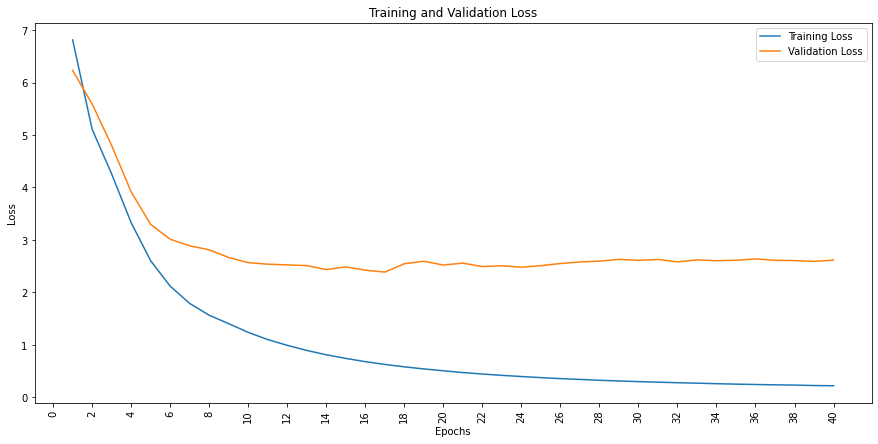

In [ ]:
# Load the training and validation loss dictionaries
from pickle import load
import matplotlib.pyplot as plt
train_loss = load(open('train_loss.pkl', 'rb'))
val_loss = load(open('val_loss.pkl', 'rb'))
plt.figure(figsize= (15,7))
# Retrieve each dictionary's values
train_values = train_loss.values()
val_values = val_loss.values()
# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 41)
# Plot and label the training and validation loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Set the tick locations
plt.xticks(np.arange(0, 41, 2))
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.show()

In [ ]:
# Create model


In [ ]:
class Translate(tf.Module):
    def __init__(self, inferencing_model, **kwargs):
        super().__init__(**kwargs)
        self.transformer = inferencing_model

    def __call__(self, sentence):
    # Append start and end of string tokens to the input sentence
        sentence = [remove_punctuation(i) for i in sentence]
        sentence = ['<SOS> ' + i + ' <EOS>' for i in sentence]
        # Prepare the input sentence by tokenizing, padding and converting to tensor
        tokenized_sentence = tf.data.Dataset.from_tensor_slices(tf.cast(sentence, tf.string))
        tokenized_sentence = tokenized_sentence.map(eng_vectorize_layer).padded_batch(batch_size=1)
        encoder_input = next(iter(tokenized_sentence))
        output_start = tf.convert_to_tensor(german_vectorize_layer.get_vocabulary().index('sos'), dtype = int64)
        output_end = tf.convert_to_tensor(german_vectorize_layer.get_vocabulary().index('eos'), dtype = int64)
        decoder_output = tf.expand_dims([output_start] * len(sentence), 1)
        for i in range(dec_seq_length):
            # Predict an output token
            prediction,encoder_attention_weights,decoder_attention_weights = self.transformer(encoder_input,decoder_output,training=False)
            #prediction = tf.transpose(prediction, perm=[1, 0, 2])
            prediction = prediction[:, -1, :]
            # Select the prediction with the highest score
            predicted_id = tf.argmax(prediction, axis=-1, output_type=tf.int64)
            predicted_id = tf.expand_dims(predicted_id, 1)
            # Write the selected prediction to the output array at the next
            # available index
            #predicted_id = tf.reshape(predicted_id, (batch_size, 1))
            decoder_output = tf.concat([decoder_output, predicted_id], axis=1)
            # Break if an <EOS> token is predicted
            if predicted_id[0] == output_end:
                break
        output = decoder_output.numpy()
        #print(output)
        output_str = []
        # Decode the predicted tokens into an output string
        for i in range(output.shape[0]):
            key = output[i]
            #print(key)
            output_str.append([german_vectorize_layer.get_vocabulary()[i] for i in key])
        return output_str,encoder_attention_weights,decoder_attention_weights

In [ ]:
inferencing_model = TransformerModel(enc_vocab_size, dec_vocab_size, enc_seq_length,
dec_seq_length, h, d_k, d_v, d_model, d_ff, n, 0)
inferencing_model.load_weights('/content/drive/MyDrive/weights_transformer/wghts40.ckpt')
sentence = ['can you understand this language?']
translator = Translate(inferencing_model)
translated_sentence, encoder, decoder = translator(sentence)
print(translated_sentence)

[['sos', 'kann', 'es', 'möglich', 'verstehen', 'sich', 'auf', 'diese', 'sprache', 'zu', 'verstehen', 'zu', 'verstehen', 'eos']]


In [ ]:
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import joblib

In [ ]:
filename = '/content/drive/MyDrive/weights_transformer/finalized_model.sav'
joblib.dump(inferencing_model, filename)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...decoder
......decoder_layer
.........decoder_layer
............add_norm1
...............layer_norm
..................vars
.....................0
.....................1
...............vars
............add_norm2
...............layer_norm
..................vars
...............vars
............add_norm3
...............layer_norm
..................vars
.....................0
.....................1
...............vars
............dropout1
...............vars
............dropout2
...............vars
............dropout3
...............vars
............feed_forward
...............activation
..................vars
...............fully_connected1
..................vars
.....................0
.....................1
...............fully_connected2
..................vars
.....................0
.....................1
...............vars
............multihead_attention1
...............W_k
..................vars
.....................

['/content/drive/MyDrive/weights_transformer/finalized_model.sav']